In [1]:
import os
import pprint
import random
import numpy as np
import torch
import torch.nn.parallel
import torch.optim
import itertools
import argparse
import json
import tqdm
from evaluation.task_inference_results import process_peaks
from dataset import dataset_utils
from PIL import Image
import decord
from evaluation.test_dataloader import get_bbox_from_data
import imageio
import matplotlib.patches as patches
import cv2
from tqdm import tqdm

from config.config import config, update_config
from utils import exp_utils
from evaluation import eval_utils

import matplotlib.pyplot as plt
from scipy.signal import find_peaks, medfilt

/vision/hwjiang/anaconda3/envs/vq2d/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mode = 'val'
annotation_path = os.path.join('/vision/hwjiang/episodic-memory/VQ2D/data', 'vq_{}.json'.format(mode))
with open(annotation_path) as fp:
    annotations = json.load(fp)
clipwise_annotations_list = eval_utils.convert_annotations_to_clipwise_list(annotations)

In [13]:
num_sample = 0
sum_query_frame = 0
for _, annots in clipwise_annotations_list.items():
    clip_uid = annots[0]["clip_uid"]
    clip_dir = '/vision/srama/Research/Ego4D/episodic-memory/VQ2D/data/clips_fullres'
    if clip_uid is None:
        continue
    clip_path = os.path.join(clip_dir, clip_uid  + '.mp4')
    keys = [
            (annot["metadata"]["annotation_uid"], annot["metadata"]["query_set"])
            for annot in annots
        ]
    for key, annot in zip(keys, annots):
        num_sample += 1
        annotation_uid = annot["metadata"]["annotation_uid"]
        query_set = annot["metadata"]["query_set"]
        annot_key = f"{annotation_uid}_{query_set}"
        query_frame = annot["query_frame"]
        sum_query_frame += int(query_frame)
        #print(query_frame, sum_query_frame / num_sample)
    # if num_sample > 1000:
    #     break

In [14]:
sum_query_frame, num_sample, sum_query_frame / num_sample

(3143830, 4504, 698.0084369449378)

In [3]:
cache_path ='/vision/hwjiang/vq2d/output/ego4d_vq2d/vq2d_all_transformer2_anchor_dinov2_inference_egotracks/default-arch_aug-no_anchor_focal-w10_2heads_dropout0.2_positive0.3_egotrack_fix-assign_res16_inference/inference_cache_val'

In [4]:
def draw_scores(pred, gt, annot_key, name):
    '''
    both in shape [N]
    '''
    assert name in ['raw', 'smooth', 'smooth_thresh']
    save_path = './visualization/plot_scores'
    os.makedirs(save_path, exist_ok=True)

    N = pred.shape[0]
    x = np.arange(N)

    pred_sm = medfilt(pred, kernel_size=5)
    peaks, _ = find_peaks(pred_sm)
    peaks = process_peaks(peaks, pred_sm)
    recent_peak = None
    for peak in peaks[::-1]:
        recent_peak = peak
        break
    if recent_peak is not None:
        threshold = pred_sm[recent_peak] * 0.5
        latest_idx = [recent_peak]
        for idx in range(recent_peak, 0, -1):
            if pred_sm[idx] >= threshold:
                latest_idx.append(idx)
            else:
                break
        for idx in range(recent_peak, N):
            if pred_sm[idx] >= threshold:
                latest_idx.append(idx)
            else:
                break
    else:
        latest_idx = [N-2]
    latest_idx = sorted(list(set(latest_idx)))

    pred_latest = pred_sm.copy()
    for i in range(pred_latest.shape[0]):
        if i not in latest_idx:
            pred_latest[i] = 0

    if name == 'raw':
        plt.plot(x, pred, marker=None, color='b', label='pred')
    elif name == 'smooth':
        plt.plot(x, pred_sm, marker=None, color='g', label='pred_sm')
        plt.plot(x[peaks], pred_sm[peaks], marker='o', ls='')
    else:
        plt.plot(x, pred_latest, marker=None, color='g', label='pred_sm_thre')
    plt.plot(x, gt, marker=None, color='r', label='gt')
    plt.xlabel('number of frames')
    plt.ylabel('occurance score')
    plt.ylim((0.0, 1.05))
    plt.legend(loc='best')

    plt.savefig(os.path.join(save_path, annot_key + f'_{name}.jpg'))
    plt.close()

In [19]:
i = 50
for _, annots in clipwise_annotations_list.items():
    clip_uid = annots[0]["clip_uid"]
    clip_dir = '/vision/srama/Research/Ego4D/episodic-memory/VQ2D/data/clips_fullres'
    clip_path = os.path.join(clip_dir, clip_uid  + '.mp4')
    keys = [
            (annot["metadata"]["annotation_uid"], annot["metadata"]["query_set"])
            for annot in annots
        ]
    for key, annot in zip(keys, annots):

        annotation_uid = annot["metadata"]["annotation_uid"]
        query_set = annot["metadata"]["query_set"]
        annot_key = f"{annotation_uid}_{query_set}"
        query_frame = annot["query_frame"]
        visual_crop = annot["visual_crop"]
        
        save_path = os.path.join(cache_path, f'{annot_key}.pt')
        cache = torch.load(save_path)
        ret_bboxes, ret_scores = cache['ret_bboxes'], torch.sigmoid(cache['ret_scores'])
        #print(ret_scores.shape, query_frame)

        gt_scores = torch.zeros_like(ret_scores)
        gt_idx = []
        for it in annot['response_track']:
            gt_idx.append(it['frame_number'])

        gt_idx = [min(it, gt_scores.shape[0]-1) for it in gt_idx]
        gt_scores[gt_idx] = 1.0

        draw_scores(ret_scores.numpy(), gt_scores.numpy(), annot_key, 'raw')
        draw_scores(ret_scores.numpy(), gt_scores.numpy(), annot_key, 'smooth')
        draw_scores(ret_scores.numpy(), gt_scores.numpy(), annot_key, 'smooth_thresh')
        i -= 1
    if i == 0:
        break

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

3760b439-d94b-4d76-8b39-1bb355800649_3


  3%|▎         | 42/1433 [00:21<11:59,  1.93it/s] 


KeyboardInterrupt: 

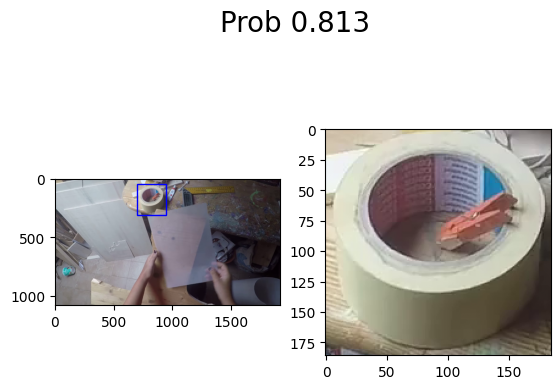

In [60]:
i = 50
for _, annots in clipwise_annotations_list.items():
    clip_uid = annots[0]["clip_uid"]
    clip_dir = '/vision/srama/Research/Ego4D/episodic-memory/VQ2D/data/clips_fullres'
    clip_path = os.path.join(clip_dir, clip_uid  + '.mp4')
    keys = [
            (annot["metadata"]["annotation_uid"], annot["metadata"]["query_set"])
            for annot in annots
        ]
    for key, annot in zip(keys, annots):

        annotation_uid = annot["metadata"]["annotation_uid"]
        query_set = annot["metadata"]["query_set"]
        annot_key = f"{annotation_uid}_{query_set}"
        query_frame = annot["query_frame"]
        visual_crop = annot["visual_crop"]
        print(annot_key)

        save_path = os.path.join(cache_path, f'{annot_key}.pt')
        cache = torch.load(save_path)
        ret_bboxes, ret_scores = cache['ret_bboxes'], torch.sigmoid(cache['ret_scores'])
        
        clip_reader = decord.VideoReader(clip_path, num_threads=1)
        owidth, oheight = visual_crop["original_width"], visual_crop["original_height"]
        oshape = (owidth, oheight)

        # get query
        query = load_query(clip_reader, visual_crop, clip_path)     # [c,h,w]
        query_name = os.path.join(os.path.join('./visualization/plot_peak_bbox', annot_key + '_query.jpg'))
        query.save(query_name)

        # get peak detections
        peaks_idx = get_peaks(ret_scores)
        peaks_bbox = ret_bboxes[peaks_idx]
        #visualize_peak_bbox(peaks_idx, peaks_bbox, clip_reader, query_name.replace('query.jpg', 'peak_crops.jpg'))

        # visualize the full video track
        visualize_video(query_frame, query, ret_scores, ret_bboxes, annot, clip_reader, query_name)

        

In [59]:
def visualize_video(query_frame, query, prob, bbox, annot, clip_reader, query_name):
    save_path = query_name.replace('query.jpg', 'video.mp4')
    writer = imageio.get_writer(save_path, fps=5)
    writer_rt = imageio.get_writer(save_path.replace('video.mp4', 'rt.mp4'), fps=5)

    frame_idx = list(range(query_frame))
    clips = clip_reader.get_batch(frame_idx)
    clips = clips.float() / 255
    clips = clips.permute(0, 3, 1, 2)     # [N,3,h,w]

    query = torch.from_numpy(np.asarray(query) / 255.0)  # [h,w,3]

    gt_idx = []
    gt_bbox = np.zeros_like(bbox)
    for it in annot['response_track']:
        gt_idx.append(it['frame_number'])
        gt_bbox[it['frame_number']][0] = it['x']
        gt_bbox[it['frame_number']][1] = it['y']+it['width']
        gt_bbox[it['frame_number']][2] = it['x']
        gt_bbox[it['frame_number']][3] = it['y']+it['height']

    T, _, H, W = clips.shape
    _, H2, W2 = query.shape

    frames = []
    for i in tqdm(range(T)):
        cur_clip = clips[i].clamp(min=0.0, max=1.0).permute(1,2,0).numpy()
        cur_query = query.clamp(min=0.0, max=1.0).numpy()
        cur_bbox = bbox[i]#.clamp(min=0.0, max=1.0)
        cur_prob = prob[i]

        fig, ax = plt.subplots(1,2)
        fig.suptitle('Prob {:.3f}'.format(cur_prob.item()), fontsize=20)
        ax[0].imshow(cur_clip)
        ax[1].imshow(cur_query)
        if i in gt_idx:
            draw_bbox_pred = gt_bbox[i]
            rect = patches.Rectangle((draw_bbox_pred[0], draw_bbox_pred[1]), 
                                      draw_bbox_pred[2]-draw_bbox_pred[0], draw_bbox_pred[3]-draw_bbox_pred[1], 
                                      linewidth=1, edgecolor='r', facecolor='none')
            ax[0].add_patch(rect)
        if cur_prob.item() > 0.5:
            draw_bbox_pred = cur_bbox #dataset_utils.recover_bbox(cur_bbox, H, W)  # [4]
            rect = patches.Rectangle((draw_bbox_pred[0], draw_bbox_pred[1]), 
                                      draw_bbox_pred[2]-draw_bbox_pred[0], draw_bbox_pred[3]-draw_bbox_pred[1], 
                                      linewidth=1, edgecolor='b', facecolor='none')
            ax[0].add_patch(rect)
        plt.savefig(save_path.replace('video.mp4', 'tmp.jpg'))
        plt.close()
        writer.append_data(cv2.imread(save_path.replace('video.mp4', 'tmp.jpg')))
        if i in gt_idx:
            writer_rt.append_data(cv2.imread(save_path.replace('video.mp4', 'tmp.jpg')))
    writer.close()
    writer_rt.close()

In [37]:
def visualize_peak_bbox(peaks_idx, peaks_bbox, clip_reader, crops_save_name):
    peaks_img = clip_reader.get_batch(peaks_idx)
    peaks_img = peaks_img.float() / 255
    peaks_img = peaks_img.permute(0, 3, 1, 2)     # [N,3,h,w]

    peaks_bbox = dataset_utils.bbox_torchTocv2(peaks_bbox)

    all_crops = []
    for img, bbox in zip(peaks_img, peaks_bbox):
        x1, y1, x2, y2 = bbox.int()
        crop = img[:,x1:x2, y1:y2]
        crop = torch.nn.functional.interpolate(crop.unsqueeze(0), size=(128,128), mode='bilinear').squeeze(0).permute(1,2,0).numpy()
        all_crops.append(crop)
    
    num_peaks = len(peaks_idx)
    fig, ax = plt.subplots(1,num_peaks)
    for i in range(num_peaks):
        ax[i].imshow(all_crops[i])
        ax[i].set_axis_off()
    plt.savefig(crops_save_name, dpi=200)
    plt.close()   
    

In [14]:
def get_peaks(preds):
    N = preds.shape[0]
    x = np.arange(N)

    pred_sm = medfilt(preds, kernel_size=5)
    peaks, _ = find_peaks(pred_sm)
    peaks = process_peaks(peaks, pred_sm)
    return peaks

In [11]:
def load_query(clip_reader, visual_crop, clip_path):
    '''
    return: in shape [c,h,w] RGB
    '''
    # load query frame
    vc_fno = visual_crop["frame_number"]
    owidth, oheight = visual_crop["original_width"], visual_crop["original_height"]
    if vc_fno >= len(clip_reader):
        print(
            "=====> WARNING: Going out of range. Clip path: {}, Len: {}, j: {}".format(
                clip_path, len(clip_reader), vc_fno
            )
        )
    query = clip_reader.get_batch([vc_fno])[0].numpy()  # RGB format, [h,w,3]
    if (query.shape[0] != oheight) or (query.shape[1] != owidth):
        query = cv2.resize(query, (owidth, oheight))
    query = Image.fromarray(query)

    # load bounding box annotation and process
    bbox = get_bbox_from_data(visual_crop)     # BoxMode.XYXY_ABS, for crop only
    bbox = dataset_utils.bbox_cv2Totorch(torch.tensor(bbox))
    bbox = dataset_utils.create_square_bbox(bbox, oheight, owidth)
    bbox = dataset_utils.bbox_torchTocv2(bbox).tolist()

    # crop image to get query
    query = query.crop((bbox[0], bbox[1], bbox[2], bbox[3]))
    return query